In [1]:
# importing the necessary packages and creating the display function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt 

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=2)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

### Output Demodulation

Original noise (left), noise after modulated convolution (middle), noise after two modulated convolutions (right)


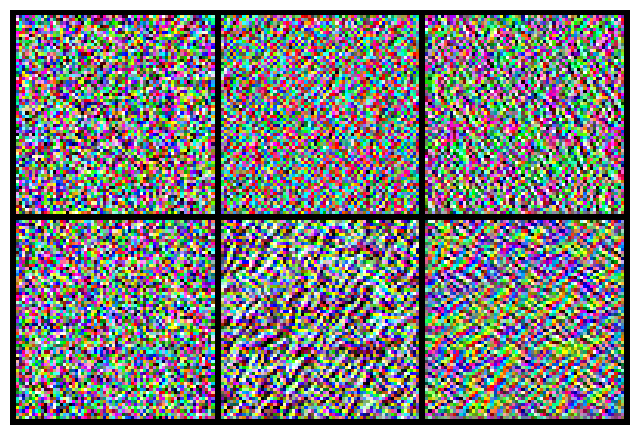

In [56]:
class ModulatedConv2d(nn.Module):
    
    def __init__(self, w_dim, in_channels, out_channels, kernel_size, padding=1):
        
        super().__init__()
        self.conv_weight = nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size)
        )
        self.style_scale_transform = nn.Linear(w_dim, in_channels)
        self.eps = 1e-6
        self.padding = padding
        
    def forward(self, image, w):
        
        # There is a more efficient (vectorized) way to do this using the group parameter of F.conv2d,
        # but for simplicity and readibility you will go through one image at a time.
        images = []
        
        for i, w_cur in enumerate(w):
            
            # Calculate the style scale factor
            style_scale = self.style_scale_transform(w_cur)
            
            # Multiply it by corresponding weight to get the new weights
            w_prime = self.conv_weight * style_scale[None, :, None, None]
            
            # Demodulate the new weights based on the current formula
            w_prime_prime = w_prime / torch.sqrt(
                (w_prime ** 2).sum([1, 2, 3])[:, None, None, None] + self.eps
            )
            images.append(F.conv2d(image[i][None, :, :, :], w_prime_prime, padding=self.padding))
            
        return torch.cat(images)
    
example_modulated_conv = ModulatedConv2d(w_dim=128, in_channels=3, out_channels=3, kernel_size=3)
num_ex = 2
image_size = 64
rand_image = torch.randn(num_ex, 3, image_size, image_size) # A 64x64 image with 3 channels
rand_w = torch.rand(num_ex, 128)
new_image = example_modulated_conv(rand_image, rand_w)
second_modulated_conv = ModulatedConv2d(w_dim=128, in_channels=3, out_channels=3, kernel_size=3)
second_image = second_modulated_conv(new_image, rand_w)

print("Original noise (left), noise after modulated convolution (middle), noise after two modulated convolutions (right)")
plt.rcParams['figure.figsize'] = [8, 8]
show_tensor_images(torch.stack([rand_image, new_image, second_image], 1).view(-1, 3, image_size, image_size))

### Path Length Regularization


$\mathop{\mathrm{J}_{\mathrm{w}}}={\partial g(\mathrm{w})} / {\partial \mathrm{w}}$.

In [57]:
class SimpleGenerator(nn.Module):
    
    def __init__(self, w_dim, in_channels, hid_channels, out_channels, kernel_size, padding=1, init_size=64):
        super().__init__()
        self.w_dim = w_dim
        self.init_size = init_size
        self.in_channels = in_channels
        self.c1 = ModulatedConv2d(w_dim, in_channels, hid_channels, kernel_size)
        self.activation = nn.ReLU()
        self.c2 = ModulatedConv2d(w_dim, hid_channels, out_channels, kernel_size)
        
    def forward(self, w):
        
        image = torch.randn(len(w), self.in_channels, self.init_size, self.init_size).to(w.device)
        y = self.c1(image, w)
        y = self.activation(y)
        y = self.c2(y, w)
        return y

In [58]:
from torch.autograd import grad

def path_length_regularization_loss(generator, w, a):
    
    # Generate the images from w
    fake_images = generator(w)
    
    # Getting the corresponding random images
    random_images = torch.randn_like(fake_images)
    
    # Output variation that we'd like to regularize
    output_var = (fake_images * random_images).sum()
    
    # Calculate the gradient with respect to the inputs 
    cur_grad = grad(outputs=output_var, inputs=w)[0]
    
    # Calculate the distance from a 
    penalty = ((cur_grad - a) ** 2).sum().sqrt()
    
    return penalty, output_var

simple_gen = SimpleGenerator(w_dim=128, in_channels=3, hid_channels=64, out_channels=3, kernel_size=3)
samples = 10
test_w = torch.randn(samples, 128).requires_grad_()
a = 10

penalty, variation = path_length_regularization_loss(simple_gen, test_w, a=a)

decay = 0.001
new_a = a * (1 - decay) + variation * decay
print(f"Old a: {a}; new a: {new_a.item()}")

Old a: 10; new a: 9.782617568969727
